In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import pairwise_distances
from fastdtw import fastdtw
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from utils import *

import wandb
from wandb.xgboost import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [10]:
df_first = pd.read_csv(r'data\cleaned_data\5_household\power\SFH36_demand_W.csv', index_col=0, parse_dates=True)

#df_first = pd.read_csv(r"C:\Users\nik\iCloudDrive\PhD_Icloud\PhD_Papers\Berkeley\Data\load_data_15min_watts.csv", index_col=0, parse_dates=True).iloc[:,-1:]


dtw_scorer = make_scorer(dtw_metric, greater_is_better=False)

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


In [16]:
config_features = {
    'scale_target': True,
    'holidays': False,
    'peaks': True,
    'boxcox': False,
    'lam': None,
    'cumsum': False,
    'lagged_days': 0,
    'scale_features': True,
    'datetime': True,
    }


model_params = { 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor',
    'objective': 'reg:pseudohubererror',
    'eval_metric': dtw_scorer,
    'colsample_bytree': 1.0,
    'learning_rate': 0.3, 
    'max_depth': 12,
    'n_estimators': 200, 
    'subsample': 0.5,
    'reg_alpha': 0, 
    'reg_lambda': 0.05, 
    'gamma': 0.1

    }


In [ ]:

#-----------------------#
df = remove_duplicate_index(df_first)

df = remove_days(df)

df[df<=0] = 1e-6 # because of log transform

#-----------------------#

### Feature Engineering ###
#-----------------------#
if config_features['boxcox']:
    df, config_features['lam'] = boxcox_transform(df)

# scaling the data

scaler = None
if config_features['scale_target']:
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])


# long to wide format, because we are doing daily predictions
df_pivot = timeseries_dataframe_pivot(df).dropna()
n_timesteps_per_day = df_pivot.shape[1]

# peaks
if config_features['peaks']:
    df_peak_feature = timeseries_peak_feature_extractor(df)
    df_peak_feature_shifted = df_peak_feature.shift(1)
    df_pivot = pd.concat([df_pivot, df_peak_feature_shifted], axis=1).dropna()
    df_pivot.index = pd.to_datetime(df_pivot.index)


# past information
lagged_days = config_features['lagged_days']
if config_features['cumsum']:
    #df = calc_rolling_sum_of_load(df, 7)
    #df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_day].sum(axis=1).shift(1)
    for i in range(2,lagged_days+1):
        df = pd.concat([df_pivot, df_pivot.iloc[:,:n_timesteps_per_day].shift(i)],axis=1).dropna()

# holidays
if config_features['holidays']:
    years = get_year_list(df_pivot)
    df_holidays_dummies = get_holidays(years, "US")
    df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
    df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

# datetime features
if config_features['datetime']:
    df_pivot = create_datetime_features(df_pivot)


df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

#-----------------------#


In [12]:

# split the data into train and test
test_size = 0.2
train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_day]).index

train = train.values
test = test.values

#features and target
X_train = train[:,n_timesteps_per_day:]
y_train = train[:,:n_timesteps_per_day]

X_test = test[:,n_timesteps_per_day:]
y_test = test[:,:n_timesteps_per_day]

# scale the data
if config_features['scale_features']:
    scaler_features = MinMaxScaler()
    X_train = scaler_features.fit_transform(X_train)
    X_test = scaler_features.transform(X_test)




In [13]:
# define the model
model = XGBRegressor(
    **model_params)

# fit the model
model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=make_scorer(dtw_metric, greater_is_better=False),
             feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:pseudohubererror',
             predictor='gpu_predictor', ...)

In [17]:
predictions = model.predict(X_test)
predictions_reshaped = post_process_xgb_predictions(predictions, config_features['boxcox'], scaler, config_features['lam'])

In [18]:
# create the persistence benchmarks
gt_long = df_first.loc[test_idx]
benchmark_day = gt_long.shift(n_timesteps_per_day).fillna(0).values.flatten() # previous day
benchmark_week = gt_long.shift(n_timesteps_per_day*7).fillna(0).values.flatten() # same day of previous week
gt = gt_long.values.flatten()


### Visualization for the resolution

In [19]:
df_compare = pd.DataFrame({'gt':gt, 
                            'predictions': predictions_reshaped,
                            'benchmark_day': benchmark_day,
                            'benchmark_week': benchmark_week}, index=test_idx
                            )[96*7:]

px.line(df_compare,  title='XGBoost Regression')

In [ ]:
df_metrics = calc_metrics(df_compare, [mean_squared_error, mean_absolute_error])
df_metrics


,root_mean_squared_error,mean_absolute_error
predictions,277.003363,139.117725
benchmark_day,403.640343,185.307978
benchmark_week,390.360192,177.251155


### Visualization For Daily Energy

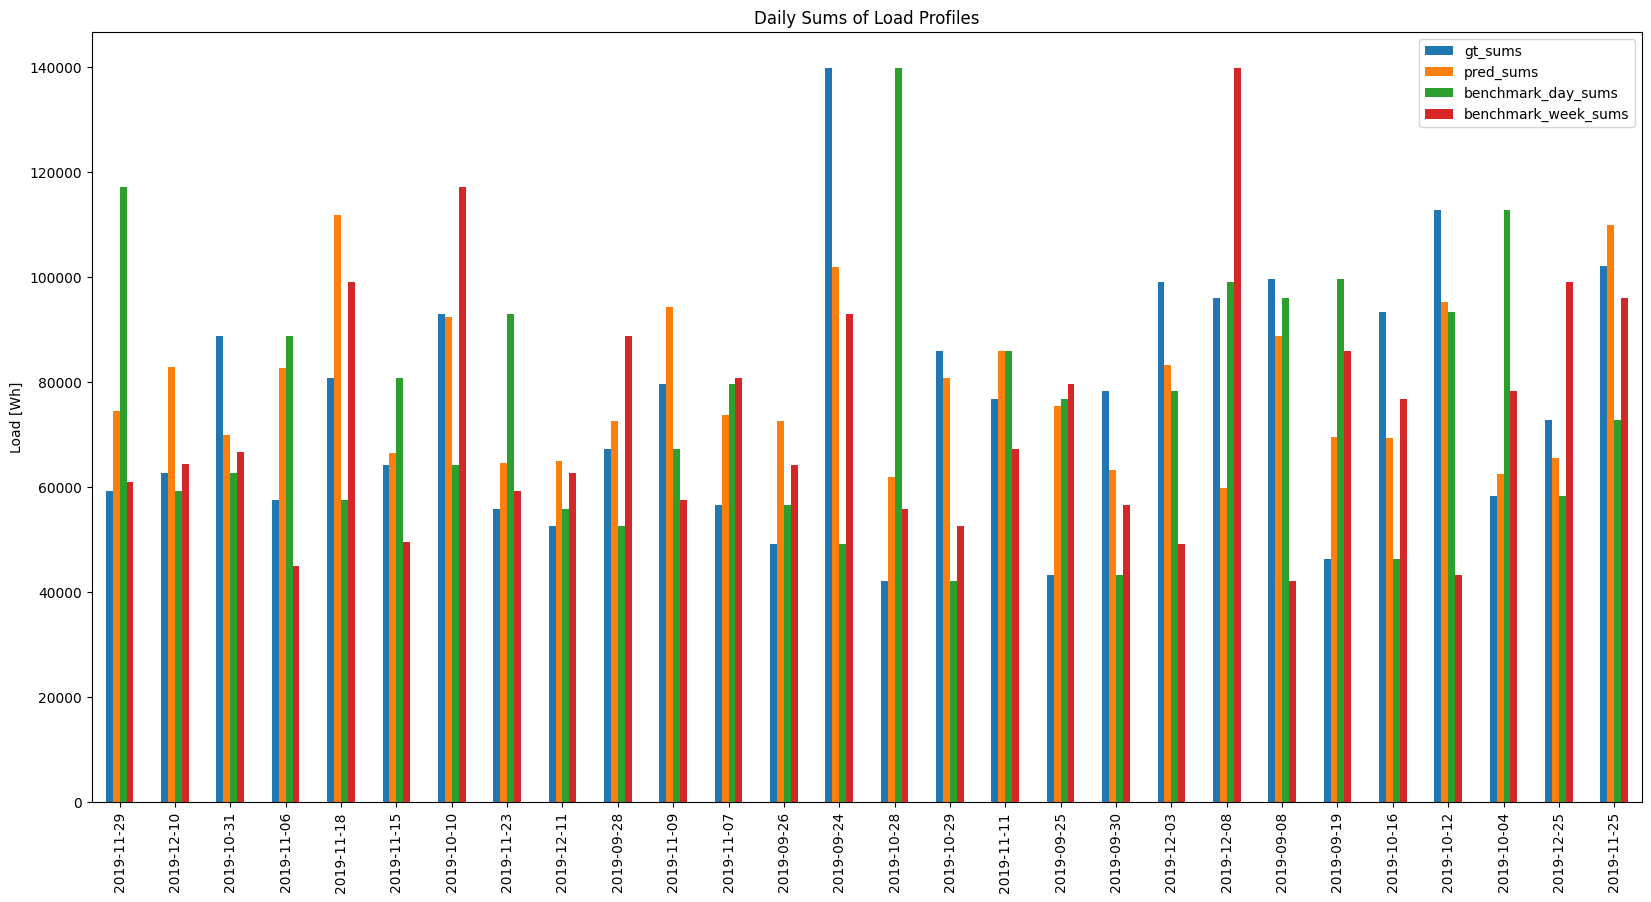

In [32]:

start_later = 7
benchmark_day_per_day = benchmark_day.reshape(predictions.shape)[start_later:]
benchmark_week_per_day = benchmark_week.reshape(predictions.shape)[start_later:]
predictions_per_day = predictions_reshaped.reshape(predictions.shape)[start_later:].sum(axis=1)
gt_per_day = gt.reshape(predictions.shape)[start_later:].sum(axis=1)

df_daily_sum = pd.DataFrame({ 
                            'gt_sums':gt_per_day,
                            'pred_sums': predictions_per_day,
                            'benchmark_day_sums': benchmark_day_per_day.sum(axis=1),
                            'benchmark_week_sums': benchmark_week_per_day.sum(axis=1)
                             }, index=list(set(test_idx.date))[start_later:]
                             )[:28] * 4

df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))
plt.ylabel('Load [Wh]')
plt.show()

In [33]:
df_metrics_daily = calc_metrics(df_daily_sum, [mean_squared_error,mean_absolute_error])
df_metrics_daily

,root_mean_squared_error,mean_absolute_error
pred_sums,19219.049828,16457.450106
benchmark_day_sums,38297.690041,30030.123138
benchmark_week_sums,29622.851585,24366.531484


### Wandb

In [34]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
        'name': 'dtw',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.5]
        },
        'n_estimators': {
            'values': [50, 100]
        },

        'datetime': {
            'values': [True, False]
        },
        'holidays': {
            'values': [True, False]
        },
}
}


In [36]:

wandb.init(
    project="XGBoost",
    )

wandb.config.update(config_features)

config = wandb.config


In [162]:
def train():
    config_defaults = {'tree_method': 'gpu_hist',
                    'predictor': 'gpu_predictor',
                    'objective': 'reg:pseudohubererror',
                    'eval_metric': 'rmse',
                    'colsample_bytree': 1.0, 
                    'learning_rate': 0.3,
                    'max_depth': 3, 
                    'n_estimators': 20,
                    'subsample': 0.5, 
                    'reg_alpha': 0, 
                    'reg_lambda': 0.5, 
                    'gamma': 0.1,
                    'eval_metric': dtw_metric
        
    }


    wandb.init(
        config=config_defaults
        )
    
    wandb.config.update(config_features)

    config = wandb.config



    ### Feature Engineering ###
    #-----------------------#
    if config.boxcox:
        df, config.lam = boxcox_transform(df)

    # scaling the data
    scaler = None
    if config.scale:
        scaler = MinMaxScaler()
        df[df.columns] = scaler.fit_transform(df[df.columns])

    # long to wide format, because we are doing daily predictions
    df_pivot = timeseries_dataframe_pivot(df).dropna()
    n_timesteps_per_day = df_pivot.shape[1]

    # peaks
    if config.peaks:
        df_peak_feature = timeseries_peak_feature_extractor(df)
        df_peak_feature_shifted = df_peak_feature.shift(1)
        df_pivot = pd.concat([df_pivot, df_peak_feature_shifted], axis=1).dropna()
        df_pivot.index = pd.to_datetime(df_pivot.index)


    # past information
    if config.cumsum:
        #df = calc_rolling_sum_of_load(df, 7)
        #df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_day].sum(axis=1).shift(1)
        for i in range(2,config.lagged_days+1):
            df = pd.concat([df_pivot, df_pivot.iloc[:,:n_timesteps_per_day].shift(i)],axis=1).dropna()

    # holidays
    if config.holidays:
        years = get_year_list(df_pivot)
        df_holidays_dummies = get_holidays(years, "US")
        df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
        df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

    # datetime features
    if config.datetime:
        df_pivot = create_datetime_features(df_pivot)

    df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

    #-----------------------#

    ### Splitting the data ###
    #-----------------------#
    test_size = 0.2
    train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
    test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_day]).index

    train = train.values
    test = test.values

    #features and target
    X_train = train[:,n_timesteps_per_day:]
    y_train = train[:,:n_timesteps_per_day]

    X_test = test[:,n_timesteps_per_day:]
    y_test = test[:,:n_timesteps_per_day]

    # scale the data
    if config_features['scale_features']:
        scaler_features = MinMaxScaler()
        X_train = scaler_features.fit_transform(X_train)
        X_test = scaler_features.transform(X_test)

    #-----------------------#


    model = XGBRegressor(
                        learning_rate=config.learning_rate,
                        n_estimators=config.n_estimators)
    
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, eval_metric=config.eval_metric)
    predictions = model.predict(X_test)
    predictions_reshaped = post_process_xgb_predictions(predictions, scaler, config_features)

    # create the persistence benchmarks
    gt = df_first.loc[test_idx].values.flatten()
    df_compare = pd.DataFrame({'gt':gt,
                            'predictions': predictions_reshaped}, 
                            index=test_idx
                            )
    

    # Log the metrics to wandb
    df_metrics = calc_metrics(df_compare, [mean_squared_error,mean_absolute_error])
    table = wandb.Table(dataframe=df_metrics.reset_index())
    wandb.log({"metrics": table})


    # Plot the predictions and the ground truth
    rows_to_plot = 4
    fig, ax = plt.subplots(rows_to_plot,1 , figsize=(40,20))
    for i in range(rows_to_plot):
        start = i*192
        end = start + 192
        ax[i].plot(df_compare['gt'][start:end], label='gt')
        ax[i].plot(df_compare['predictions'][start:end], label='predictions')
        ax[i].set_title(f'Day {i+1}')

    # Log the figure to wandb
    wandb.log({"Side-by-Side": wandb.Image(fig)})



sweep_id = wandb.sweep(sweep_config, project="XGBoost")
wandb.agent(sweep_id, train, count=3)
    

    
    

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 8kzw0b22
Sweep URL: https://wandb.ai/wattcast/XGBoost/sweeps/8kzw0b22


wandb: Agent Starting Run: vcaau4s8 with config:
wandb: 	learning_rate: 0.5
wandb: 	n_estimators: 100


wandb: ERROR Run vcaau4s8 errored: AttributeError("<class 'wandb.sdk.wandb_config.Config'> object has no attribute 'objective'")
wandb: Agent Starting Run: 2pmtk1fw with config:
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 50


wandb: ERROR Run 2pmtk1fw errored: AttributeError("<class 'wandb.sdk.wandb_config.Config'> object has no attribute 'objective'")
wandb: Agent Starting Run: z25hrubu with config:
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 100


Problem at: C:\Users\nik\AppData\Local\Temp\ipykernel_11716\2871594230.py 18 train


Traceback (most recent call last):
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\wandb_init.py", line 1144, in init
    run = wi.init()
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\wandb_init.py", line 801, in init
    run_start_result = run_start_handle.wait(timeout=30)
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\lib\mailbox.py", line 283, in wait
    found, abandoned = self._slot._get_and_clear(timeout=wait_timeout)
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\lib\mailbox.py", line 130, in _get_and_clear
    if self._wait(timeout=timeout):
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\wandb\sdk\lib\mailbox.py", line 126, in _wait
    return self._event.wait(timeout=timeout)
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\threading.py", line 607, in wait
    signaled = self._cond.wait(timeout)
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\threading.py", line 324, in wait
   

: 

: 

In [209]:
# Define the parameter grid for the random search
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1]
}

# Define the function to compute the DTW distance
def dtw_dist(predt, actuals, metric_name='dtw'):
    dist, _ = dtw(actuals, predt, dist=lambda x, y: np.abs(x - y))
    return 'dtw', dist

# Define the XGBoost regressor

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=dtw_dist)

# Perform the random grid search
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=2,
    cv=3,
    scoring=dtw_dist,
    random_state=42
)
random_search.fit(X_train, y_train)

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\nik\AppData\Local\Temp\ipykernel_14120\3905269989.py", line 10, in dtw_dist
    dist, _ = dtw(actuals, predt, dist=lambda x, y: np.abs(x - y))
  File "c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\dtw\dtw.py", line 19, in dtw
    assert len(y)
TypeError: object of type 'XGBRegressor' has no len()




RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=<function dtw_dist at 0x000001F8964175B0>,
                                          feature_types=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interacti...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=2,
                   param_distributions={'learning_rate': [0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100]},
                   random_state=42,
                   scoring=<function dtw_dist at 0x000001F8964175B0>)

In [210]:
def dtw_dist(predt, actuals, metric_name='dtw'):
    dist, _ = dtw(actuals, predt, dist=lambda x, y: np.abs(x - y))
    return 'dtw', dist

In [212]:
from xgboost import DMatrix

# Define the XGBoost regressor


dtrain = DMatrix(X_train, y_train)

dtest = DMatrix(X_test, y_test)

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=dtw_dist)

# Perform the random grid search
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=2,
    cv=3,
    scoring=dtw_dist,
    random_state=42
)


random_search.fit(dtrain)

TypeError: Singleton array array(<xgboost.core.DMatrix object at 0x000001F8A86E8CD0>, dtype=object) cannot be considered a valid collection.

In [217]:
import xgboost as xgb

# Define the XGBoost regressor
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

